# General examples of los calculations

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from sympy.printing.pretty.pretty_symbology import line_width

# Setup time new roman font for plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Computational load

The computational load is the slope of the characteristic straight line of the execution time vs simulation time.

It is assumed that the execution time distributes according to some random variable.

We test several distributions to see how they affect the ultimate distribution of the computational load.

In [13]:
from greyboxmodels.voi.metrics.computational_load import computational_load

def emulate_exec_time(tf, increment_func, n_real=50, dt=1,  **kwargs):
    """
    Emulate execution time for some simulation time.
    """
    sim_time = np.arange(0, tf, dt)
    exec_time = np.zeros((n_real, len(sim_time)))

    for i in range(n_real):
        for j in range(1, len(sim_time)):
            increment = increment_func(**kwargs)
            exec_time[i, j] = exec_time[i, j-1] + increment

    return sim_time, exec_time

### Computational load for different distributions

In [108]:
# Uniform distribution
pdf1 = stats.uniform(0.43 - 2 * 0.09, 4 * 0.09)
fun1 = lambda: pdf1.rvs()

# Normal distribution clipped to [0, inf]
pdf2 = stats.norm(0.43, 0.09)
fun2 = lambda: max(0, pdf2.rvs())

# Skew normal distribution
pdf3 = stats.skewnorm(5.72, 0.35, 0.07)
fun3 = lambda: pdf3.rvs()

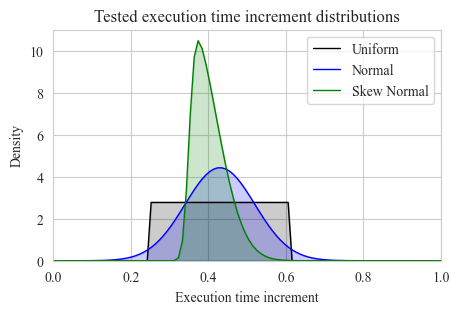

In [109]:
# Histogram of the distributions
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
x = np.linspace(0, 1, 100)

ax.plot(x, pdf1.pdf(x), color='black', linewidth=1, label='Uniform')
ax.plot(x, pdf2.pdf(x), color='blue', linewidth=1, label='Normal')
ax.plot(x, pdf3.pdf(x), color='green', linewidth=1, label='Skew Normal')
ax.fill_between(x, pdf1.pdf(x), color='black', alpha=0.2)
ax.fill_between(x, pdf2.pdf(x), color='blue', alpha=0.2)
ax.fill_between(x, pdf3.pdf(x), color='green', alpha=0.2)
ax.set_xlabel('Execution time increment')
ax.set_ylabel('Density')
ax.set_title('Tested execution time increment distributions')
ax.set_xlim([0, 1])
ax.set_ylim([0, None])
ax.legend()

In [110]:
tf = 3600 * 24 * 4  # 4 days
dt = 900

s1, e1 = emulate_exec_time(tf, fun1, n_real=100, dt=dt)
s2, e2 = emulate_exec_time(tf, fun2, n_real=100, dt=dt)
s3, e3 = emulate_exec_time(tf, fun3, n_real=100, dt=dt)

results = [(s1, e1, f"Uniform, params: {pdf1.args}"),
           (s2, e2, f"Normal, params: {pdf2.args}"),
           (s3, e3, f"Skew Normal, params: {pdf3.args}")]

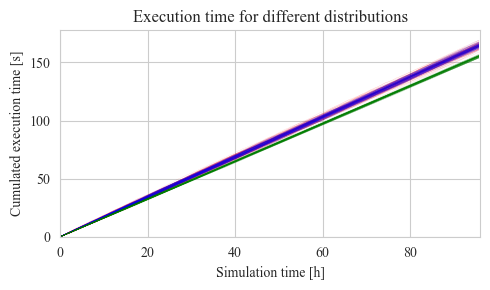

In [112]:
# Plot the execution time for each distribution
fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharey=True)
colors = ['red', 'blue', 'green']
for i in range(3):
    s, e, name = results[i]
    s = s/3600  # Convert to hours
    for j in range(e.shape[0]):
        ax.plot(s, e[j, :], linewidth=0.2, color=colors[i], alpha=0.2)
    ax.set_xlabel('Simulation time [h]')
    ax.set_ylabel('Cumulated execution time [s]')

ax.set_title("Execution time for different distributions")
ax.set_xlim([0, tf / 3600])
ax.set_ylim([0, None])

plt.tight_layout()

In [80]:
slopes1 = [computational_load(s1, e1[i, :]) for i in range(e1.shape[0])]
slopes2 = [computational_load(s2, e2[i, :]) for i in range(e2.shape[0])]
slopes3 = [computational_load(s3, e3[i, :]) for i in range(e3.shape[0])]

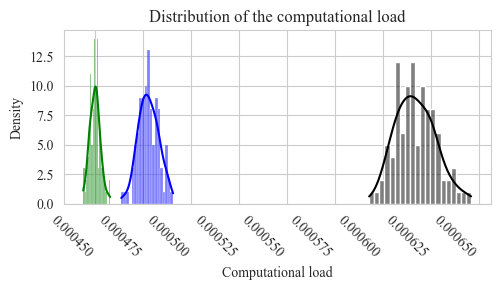

In [105]:
# Histogram of the slopes
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

sns.histplot(slopes1, color='black', kde=True, ax=ax, bins=20)
sns.histplot(slopes2, color='blue', kde=True, ax=ax, bins=20)
sns.histplot(slopes3, color='green', kde=True, ax=ax, bins=20)
ax.set_xlabel('Computational load')
ax.set_ylabel('Density')
ax.set_title('Distribution of the computational load')

# rotate the x-axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(-45)
    tick.set_ha('right')

plt.tight_layout()

In [83]:
# Test each distribution for normality
from scipy.stats import normaltest

res1 = normaltest(slopes1)
res2 = normaltest(slopes2)
res3 = normaltest(slopes3)

print(f"Uniform: {res1.statistic}, {res1.pvalue}")
print(f"Normal: {res2.statistic}, {res2.pvalue}")
print(f"Skew Normal: {res3.statistic}, {res3.pvalue}")

Uniform: 2.154129069598177, 0.34059386106541356
Normal: 0.08203408834808196, 0.9598127705924747
Skew Normal: 1.7838097859264614, 0.4098742420820226


In [2]:
# Simulation time
sim_time = np.linspace(0, 60, 100)

# Execution time realizations
n_real = 50
exec_time = np.zeros((n_real, len(sim_time)))
for i in range(n_real):
    for j in range(1, len(sim_time)):
        # increment = np.random.uniform(0.2, 1.3)
        increment = np.random.normal(1, 0.3)
        exec_time[i, j] = exec_time[i, j-1] + increment

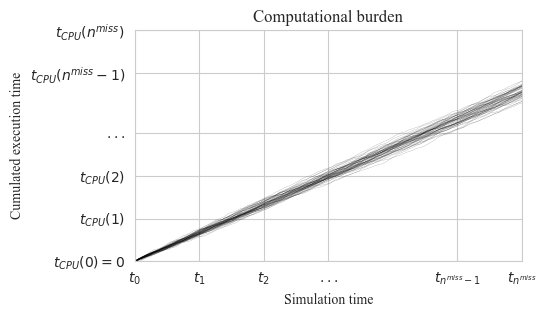

In [129]:
# Single exemplification of the execution time
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

simtime = s3
cputime = e3

# Plot each realization
for i in range(n_real):
    ax.plot(sim_time, exec_time[i, :], linewidth=0.2, color='black', alpha=0.4)

ax.set_xlabel('Simulation time')
ax.set_ylabel('Cumulated execution time')
ax.set_xlim([0, 60])
ax.set_ylim([0, 135])
ax.set_title('Computational burden')

# Modify the ticks. First, x-axis
x_pos = [0, 10, 20, 30, 50, 60]
x_label = ["$t_0$", "$t_1$", "$t_2$", "$...$", "$t_{n^{miss}-1}$", "$t_{n^{miss}}$"]
# x_label = ["$t(0)$", "$t(1)$", "$t(2)$", "$...$", "$t(\eta_l-1)$", "$t(\eta_l)$"]
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label)

# Second, y-axis
y_pos = [0, 25, 50, 75, 110, 135]
y_label = ["$t_{CPU}(0)=0$", "$t_{CPU}(1)$", "$t_{CPU}(2)$", "$...$", "$t_{CPU}(n^{miss}-1)$", "$t_{CPU}(n^{miss})$"]
# y_label = ["$t^{exec}(0)$", "$t^{exec}(1)$", "$t^{exec}(2)$", "$...$", "$t^{exec}(\eta_l-1)$", "$t^{exec}(\eta_l)$"]
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
None

(0.0, 102.02262281961067)

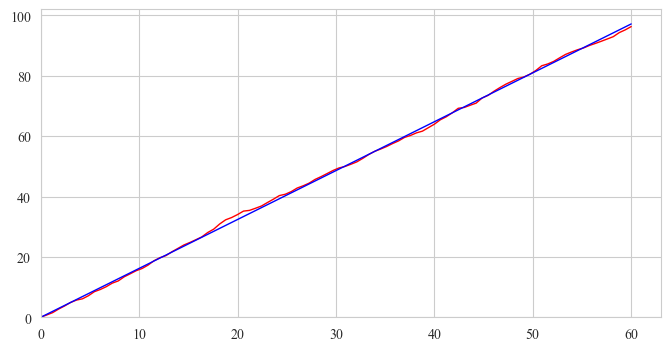

In [5]:
# View one of the realizations and the effective curve
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

i = 10  # Change to see different realizations
ax.plot(sim_time, exec_time[i, :], linewidth=1, color='red')
ax.plot(sim_time, slopes[i] * sim_time, linewidth=1, color='blue')
ax.set_xlim([0, None])
ax.set_ylim([0, None])

<Axes: ylabel='Count'>

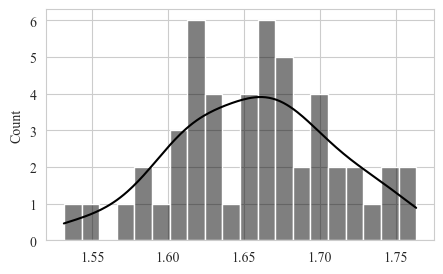

In [6]:
# View the distribution of the slopes
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

sns.histplot(slopes, color='black', kde=True, ax=ax, bins=20)

In [57]:
# Test normality using a D'Agostino and Pearson test
from scipy.stats import normaltest
res = normaltest(slopes)

In [58]:
res.statistic

0.25790436213290746

## Fidelity

The fidelity is the time-averaged Kolmogorov-Smirnov distance between the ground truth and the model predictions.

For each time step, we have a pdf for the ground truth and a pdf for the model predictions.

Then, we calculate the Kolmogorov-Smirnov distance between the two distributions for each time step.

Finally, we average the distances across all time steps.

In [2]:
sim_time = np.linspace(0, 10, 100)

In [3]:
def dummy_model(t, p0, p1, p2, n_samples=500):
    X = np.zeros((n_samples, len(t)))
    # X[:, 0] = p0 * np.ones(n_samples)
    X[:, 1] = p0 * np.ones(n_samples)
    for i in range(2, len(t)):
        X[:, i] = X[:, i-1] + p1 * X[:, i-2] + np.random.normal(0, p2, n_samples)

    return X


In [4]:
np.random.seed(42)
n_samples = 1000

# ground truth distributions
p0_gt = np.random.uniform(0.8, 1.2)
p1_gt = np.random.uniform(-1.0, -0.8)
p2_gt = np.random.uniform(0.001, 0.003)
ground_truth = dummy_model(sim_time, p0_gt, p1_gt, p2_gt, n_samples=n_samples)

print(p0_gt, p1_gt, p2_gt)

# Two models
p0_model1 = 1.0
p1_model1 = -0.9
p2_model1 = 0.002
model_predictions1 = dummy_model(sim_time, p0_model1, p1_model1, p2_model1, n_samples=n_samples)

p0_model2 = 0.95
p1_model2 = -0.85
p2_model2 = 0.0026
model_predictions2 = dummy_model(sim_time, p0_model2, p1_model2, p2_model2, n_samples=n_samples)

0.949816047538945 -0.8098571387180168 0.0024639878836228103


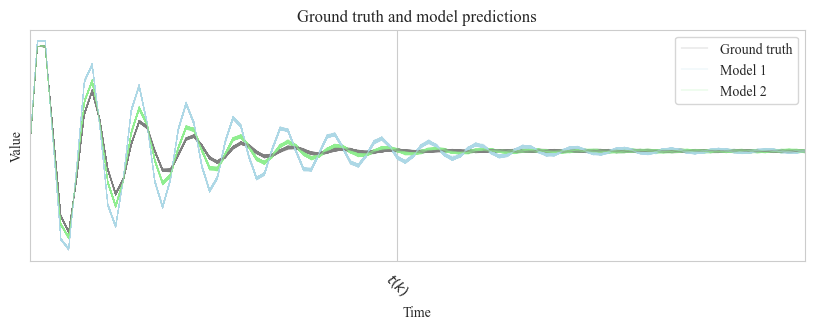

In [26]:
# Plot realizations of the ground truth and model predictions with different colors
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

for i in range(n_samples):
    ax.plot(sim_time, ground_truth[i, :], linewidth=0.2, color='gray', label='Ground truth')
    ax.plot(sim_time, model_predictions1[i, :], linewidth=0.2, color='lightblue', label='Model 1')
    ax.plot(sim_time, model_predictions2[i, :], linewidth=0.2, color='lightgreen', label='Model 2')

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Ground truth and model predictions')
ax.set_xlim([0, sim_time[-1]])

# Add the legend for the different lines, only first three
ax.legend(['Ground truth', 'Model 1', 'Model 2'])

# Modify the ticks. First, x-axis
x_pos = [sim_time[47]]
x_label = ["$t(k)$"]
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label, rotation=-45)

# Second, y-axis
y_pos = []
y_label = []
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
None

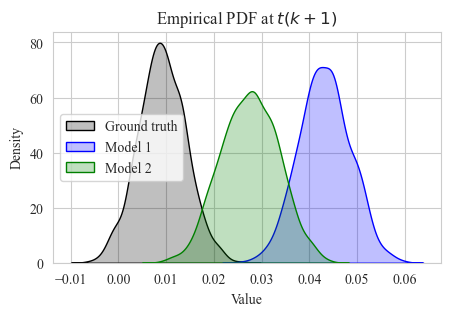

In [30]:
# Select some time and plot the distributions
k = 46

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

sns.kdeplot(ground_truth[:, k], color='black', linewidth=1, label='Ground truth', fill=True)
sns.kdeplot(model_predictions1[:, k], color='blue', linewidth=1, label='Model 1', fill=True)
sns.kdeplot(model_predictions2[:, k], color='green', linewidth=1, label='Model 2', fill=True)

ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_title(f'Empirical PDF at $t(k+1)$')
ax.legend()

None

In [33]:
# Calculate the lack of fit for fidelity at each time step
import greyboxmodels.voi.metrics.lack_of_fit as lof
from importlib import reload
reload(lof)

ks1_list = []
ks2_list = []

for i in range(len(sim_time)):
    lof1, info1 = lof.ks_statistic(model_predictions1[:, i], ground_truth[:, i])
    lof2, info2 = lof.ks_statistic(model_predictions2[:, i], ground_truth[:, i])
    ks1_list.append(info1)
    ks2_list.append(info2)


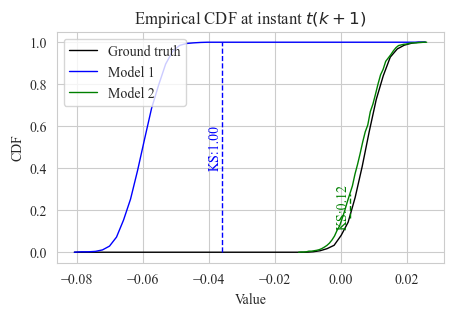

In [55]:
k = 47

# Get the CDF and KS data from the infor dictionaries
cdf_gt = ks1_list[k]['ecdf_ref']
cdf_m1 = ks1_list[k]['ecdf']
cdf_m2 = ks2_list[k]['ecdf']

# Add one more bin to the end
bins1_diff = ks1_list[k]['bins'][1] - ks1_list[k]['bins'][0]
bins1 = np.append(ks1_list[k]['bins'], ks1_list[k]['bins'][-1] + bins1_diff)

bins2_diff = ks2_list[k]['bins'][1] - ks2_list[k]['bins'][0]
bins2 = np.append(ks2_list[k]['bins'], ks2_list[k]['bins'][-1] + bins2_diff)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.plot(bins1, cdf_gt, color='black', linewidth=1, label='Ground truth')
ax.plot(bins1, cdf_m1, color='blue', linewidth=1, label='Model 1')
ax.plot(bins2, cdf_m2, color='green', linewidth=1, label='Model 2')

# Plot the KS statistic
ks1_loc = ks1_list[k]['ks_location']
ks1_val = ks1_list[k]['ecdf_at_ks'] + ks1_list[k]['ks_value']
ks1_off = ks1_list[k]['ecdf_at_ks']

ks2_loc = ks2_list[k]['ks_location']
ks2_val = ks2_list[k]['ecdf_at_ks'] + ks2_list[k]['ks_value']
ks2_off = ks2_list[k]['ecdf_at_ks']

ax.plot([ks1_loc, ks1_loc], [ks1_off, ks1_val], color='blue', linestyle='--', linewidth=1)
ax.plot([ks2_loc, ks2_loc], [ks2_off, ks2_val], color='green', linestyle='--', linewidth=1)

# Add text with the KS values next to the lines, at the vertical center of them and aligned to the right, rotated 90 degrees
ax.text(ks1_loc, (ks1_off + ks1_val) / 2, f'KS:{ks1_list[k]["ks_value"]:.2f}', color='blue', ha='right', va='center', rotation=90)
ax.text(ks2_loc, (ks2_off + ks2_val) / 2, f'KS:{ks2_list[k]["ks_value"]:.2f}', color='green', ha='right', va='center', rotation=90)

ax.set_xlabel('Value')
ax.set_ylabel('CDF')
ax.set_title(f'Empirical CDF at instant $t(k+1)$')
ax.legend(loc='upper left')

None

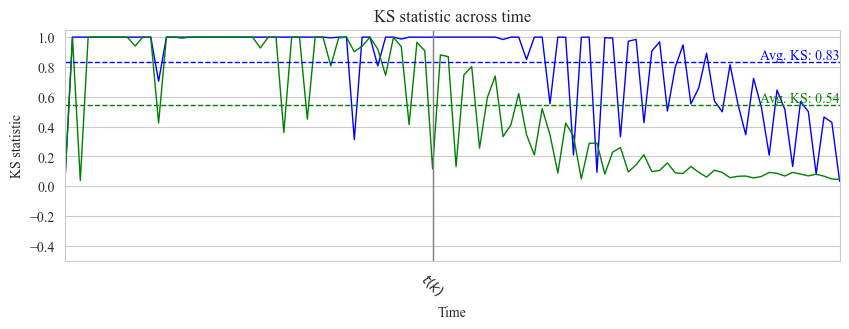

In [62]:
# Plot the KS statistic across time
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ks1_values = [ks1_list[i]['ks_value'] for i in range(len(sim_time))]
ks2_values = [ks2_list[i]['ks_value'] for i in range(len(sim_time))]
ax.plot(sim_time, ks1_values, color='blue', linewidth=1, label='Model 1')
ax.plot(sim_time, ks2_values, color='green', linewidth=1, label='Model 2')

# Average
avg_ks1 = np.mean(ks1_values)
avg_ks2 = np.mean(ks2_values)

ax.plot(sim_time, avg_ks1 * np.ones(len(sim_time)), color='blue', linestyle='--', linewidth=1, label=f'Avg. Model 1: {avg_ks1:.2f}')
ax.plot(sim_time, avg_ks2 * np.ones(len(sim_time)), color='green', linestyle='--', linewidth=1, label=f'Avg. Model 2: {avg_ks2:.2f}')

# Text with the average values, place on top of the lines
ax.text(sim_time[-1], avg_ks1, f'Avg. KS: {avg_ks1:.2f}', color='blue', ha='right', va='bottom')
ax.text(sim_time[-1], avg_ks2, f'Avg. KS: {avg_ks2:.2f}', color='green', ha='right', va='bottom')

# Highlight instant k with vertical line
ax.axvline(sim_time[k], color='gray', linewidth=1)

ax.set_xlabel('Time')
ax.set_ylabel('KS statistic')
ax.set_title('KS statistic across time')
ax.set_xlim([0, sim_time[-1]])
ax.set_ylim([-0.5, 1.05])
# ax.legend()

# Xticks
x_pos = [sim_time[k]]
x_label = ["$t(k)$"]
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label, rotation=-45)

# Yticks
# y_pos = [0, 0.1, 0.2, 0.3, 0.4]
# y_label = ["0", "0.1", "0.2", "0.3", "0.4"]
# ax.set_yticks(y_pos)
# ax.set_yticklabels(y_label)
None